In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from torch import nn, optim
from torchvision import transforms
from tqdm.auto import tqdm

import os 
import shutil

from collections import defaultdict
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

warnings.filterwarnings("ignore")
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})

device = "cuda" if torch.cuda.is_available() else "cpu"
device

from torch.utils.data import Dataset, DataLoader

import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim
from torch import nn

import torchvision.transforms as T
from torchvision.datasets import ImageFolder

from torchvision.models import mobilenet_v3_small
from PIL import Image

from sklearn.model_selection import train_test_split

print(torchvision.__version__)

0.15.2+cu118


In [16]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import defaultdict
import cv2
import pandas as pd

In [27]:
train_transform = A.Compose([
    A.Resize(32, 32),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(32, 32),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

#---------------------------Загрузка датасета, обработка---------------------------

class CustomDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.file_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(image=img)['image']
        
        label = self.labels[idx]
        return img, label
    
def load_data(data_path):
    classes = sorted(os.listdir(data_path))
    file_paths = []
    labels = []
    
    for class_id, class_name in enumerate(classes):
        class_path = os.path.join(data_path, class_name)
        for img_name in os.listdir(class_path):
            file_paths.append(os.path.join(class_path, img_name))
            labels.append(class_id)
    
    return file_paths, labels, classes

class TestDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = sorted(
            [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))],
            key=lambda x: int(os.path.splitext(x)[0])  # Сортировка по числовому ID
        )
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
            
        return img, self.image_files[idx]


#---------------------------Архитектура модели---------------------------

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(ImprovedCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
            
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
            
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
        # Инициализация весов
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=100):
    best_acc = 0.0
    history = defaultdict(list)
    early_stop_counter = 0
    patience = 10
    
    for epoch in range(num_epochs):
        # Warmup (первые 5 эпох с линейным увеличением LR)
        if epoch < 5:
            lr = 0.01 * (epoch + 1) / 5
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        
        # Обучение
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        # Валидация
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        # Обновление истории
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Обновление LR
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(val_loss)
        else:
            scheduler.step()
        
        # Сохранение лучшей модели
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            early_stop_counter = 0
        else:
            early_stop_counter += 1
        
        # Ранняя остановка
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%')
    
    return history

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    loss = running_loss / len(loader)
    acc = 100. * correct / total
    return loss, acc

def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    

Epoch 1/50: 100%|██████████| 119/119 [00:02<00:00, 52.73it/s]


Epoch 1: Train Loss: 4.2637, Acc: 6.57% | Val Loss: 3.7775, Acc: 11.88%


Epoch 2/50: 100%|██████████| 119/119 [00:01<00:00, 96.79it/s] 


Epoch 2: Train Loss: 4.0253, Acc: 9.65% | Val Loss: 3.7062, Acc: 14.20%


Epoch 3/50: 100%|██████████| 119/119 [00:01<00:00, 96.11it/s] 


Epoch 3: Train Loss: 3.8228, Acc: 12.17% | Val Loss: 3.6161, Acc: 15.51%


Epoch 4/50: 100%|██████████| 119/119 [00:01<00:00, 98.71it/s] 


Epoch 4: Train Loss: 3.6709, Acc: 14.33% | Val Loss: 3.4429, Acc: 18.87%


Epoch 5/50: 100%|██████████| 119/119 [00:01<00:00, 93.45it/s] 


Epoch 5: Train Loss: 3.5659, Acc: 15.83% | Val Loss: 3.3395, Acc: 20.72%


Epoch 6/50: 100%|██████████| 119/119 [00:01<00:00, 95.97it/s] 


Epoch 6: Train Loss: 3.3231, Acc: 19.31% | Val Loss: 3.1816, Acc: 23.45%


Epoch 7/50: 100%|██████████| 119/119 [00:01<00:00, 96.37it/s] 


Epoch 7: Train Loss: 3.0730, Acc: 23.82% | Val Loss: 2.9249, Acc: 27.39%


Epoch 8/50: 100%|██████████| 119/119 [00:01<00:00, 97.75it/s] 


Epoch 8: Train Loss: 2.8881, Acc: 27.04% | Val Loss: 2.8247, Acc: 29.28%


Epoch 9/50: 100%|██████████| 119/119 [00:01<00:00, 97.67it/s] 


Epoch 9: Train Loss: 2.7147, Acc: 30.31% | Val Loss: 2.7262, Acc: 32.54%


Epoch 10/50: 100%|██████████| 119/119 [00:01<00:00, 94.86it/s] 


Epoch 10: Train Loss: 2.6256, Acc: 32.12% | Val Loss: 2.6867, Acc: 33.07%


Epoch 11/50: 100%|██████████| 119/119 [00:01<00:00, 95.18it/s] 


Epoch 11: Train Loss: 2.5917, Acc: 32.65% | Val Loss: 2.6816, Acc: 32.81%


Epoch 12/50: 100%|██████████| 119/119 [00:01<00:00, 99.57it/s] 


Epoch 12: Train Loss: 2.5937, Acc: 32.43% | Val Loss: 2.6741, Acc: 33.12%


Epoch 13/50: 100%|██████████| 119/119 [00:01<00:00, 93.76it/s] 


Epoch 13: Train Loss: 2.5937, Acc: 32.77% | Val Loss: 2.6661, Acc: 33.18%


Epoch 14/50: 100%|██████████| 119/119 [00:01<00:00, 95.40it/s] 


Epoch 14: Train Loss: 2.5771, Acc: 33.02% | Val Loss: 2.6649, Acc: 33.33%


Epoch 15/50: 100%|██████████| 119/119 [00:01<00:00, 97.38it/s] 


Epoch 15: Train Loss: 2.5825, Acc: 33.71% | Val Loss: 2.6520, Acc: 33.12%


Epoch 16/50: 100%|██████████| 119/119 [00:01<00:00, 95.09it/s] 


Epoch 16: Train Loss: 2.5605, Acc: 33.87% | Val Loss: 2.6342, Acc: 33.39%


Epoch 17/50: 100%|██████████| 119/119 [00:01<00:00, 97.29it/s] 


Epoch 17: Train Loss: 2.5465, Acc: 33.99% | Val Loss: 2.6227, Acc: 33.39%


Epoch 18/50: 100%|██████████| 119/119 [00:01<00:00, 98.50it/s] 


Epoch 18: Train Loss: 2.5235, Acc: 34.52% | Val Loss: 2.6023, Acc: 33.86%


Epoch 19/50: 100%|██████████| 119/119 [00:01<00:00, 97.25it/s] 


Epoch 19: Train Loss: 2.5128, Acc: 33.94% | Val Loss: 2.5880, Acc: 34.65%


Epoch 20/50: 100%|██████████| 119/119 [00:01<00:00, 95.16it/s] 


Epoch 20: Train Loss: 2.4694, Acc: 35.87% | Val Loss: 2.5817, Acc: 34.91%


Epoch 21/50: 100%|██████████| 119/119 [00:01<00:00, 96.68it/s] 


Epoch 21: Train Loss: 2.4176, Acc: 36.09% | Val Loss: 2.5944, Acc: 35.65%


Epoch 22/50: 100%|██████████| 119/119 [00:01<00:00, 95.88it/s] 


Epoch 22: Train Loss: 2.3896, Acc: 36.91% | Val Loss: 2.5724, Acc: 35.54%


Epoch 23/50: 100%|██████████| 119/119 [00:01<00:00, 93.77it/s] 


Epoch 23: Train Loss: 2.3532, Acc: 37.41% | Val Loss: 2.5288, Acc: 35.38%


Epoch 24/50: 100%|██████████| 119/119 [00:01<00:00, 95.77it/s] 


Epoch 24: Train Loss: 2.3517, Acc: 37.38% | Val Loss: 2.5309, Acc: 35.70%


Epoch 25/50: 100%|██████████| 119/119 [00:01<00:00, 95.91it/s] 


Epoch 25: Train Loss: 2.2816, Acc: 39.81% | Val Loss: 2.5074, Acc: 35.86%


Epoch 26/50: 100%|██████████| 119/119 [00:01<00:00, 99.59it/s] 


Epoch 26: Train Loss: 2.2585, Acc: 39.84% | Val Loss: 2.4982, Acc: 36.65%


Epoch 27/50: 100%|██████████| 119/119 [00:01<00:00, 96.69it/s] 


Epoch 27: Train Loss: 2.2207, Acc: 40.81% | Val Loss: 2.4828, Acc: 36.54%


Epoch 28/50: 100%|██████████| 119/119 [00:01<00:00, 97.13it/s] 


Epoch 28: Train Loss: 2.1862, Acc: 40.69% | Val Loss: 2.4768, Acc: 36.65%


Epoch 29/50: 100%|██████████| 119/119 [00:01<00:00, 96.67it/s] 


Epoch 29: Train Loss: 2.1780, Acc: 41.65% | Val Loss: 2.4763, Acc: 37.33%


Epoch 30/50: 100%|██████████| 119/119 [00:01<00:00, 95.64it/s] 


Epoch 30: Train Loss: 2.1766, Acc: 41.52% | Val Loss: 2.4762, Acc: 37.12%


Epoch 31/50: 100%|██████████| 119/119 [00:01<00:00, 98.13it/s] 


Epoch 31: Train Loss: 2.1733, Acc: 41.40% | Val Loss: 2.4765, Acc: 37.12%


Epoch 32/50: 100%|██████████| 119/119 [00:01<00:00, 99.58it/s] 


Epoch 32: Train Loss: 2.1550, Acc: 42.85% | Val Loss: 2.4730, Acc: 37.12%


Epoch 33/50: 100%|██████████| 119/119 [00:01<00:00, 94.40it/s] 


Epoch 33: Train Loss: 2.1617, Acc: 41.97% | Val Loss: 2.4743, Acc: 36.96%


Epoch 34/50: 100%|██████████| 119/119 [00:01<00:00, 98.47it/s] 


Epoch 34: Train Loss: 2.1666, Acc: 41.54% | Val Loss: 2.4743, Acc: 36.59%


Epoch 35/50: 100%|██████████| 119/119 [00:01<00:00, 96.15it/s] 


Epoch 35: Train Loss: 2.1693, Acc: 41.72% | Val Loss: 2.4738, Acc: 36.70%


Epoch 36/50: 100%|██████████| 119/119 [00:01<00:00, 98.10it/s] 


Epoch 36: Train Loss: 2.1637, Acc: 42.22% | Val Loss: 2.4854, Acc: 36.17%


Epoch 37/50: 100%|██████████| 119/119 [00:01<00:00, 99.20it/s] 


Epoch 37: Train Loss: 2.1643, Acc: 42.02% | Val Loss: 2.4830, Acc: 37.43%


Epoch 38/50: 100%|██████████| 119/119 [00:01<00:00, 96.05it/s] 


Epoch 38: Train Loss: 2.1498, Acc: 42.61% | Val Loss: 2.4561, Acc: 37.12%


Epoch 39/50: 100%|██████████| 119/119 [00:01<00:00, 96.23it/s] 


Epoch 39: Train Loss: 2.1272, Acc: 42.68% | Val Loss: 2.4652, Acc: 37.54%


Epoch 40/50: 100%|██████████| 119/119 [00:01<00:00, 95.66it/s] 


Epoch 40: Train Loss: 2.1053, Acc: 41.75% | Val Loss: 2.4813, Acc: 37.38%


Epoch 41/50: 100%|██████████| 119/119 [00:01<00:00, 96.89it/s] 


Epoch 41: Train Loss: 2.0993, Acc: 42.99% | Val Loss: 2.4437, Acc: 38.38%


Epoch 42/50: 100%|██████████| 119/119 [00:01<00:00, 98.17it/s] 


Epoch 42: Train Loss: 2.0358, Acc: 44.16% | Val Loss: 2.4073, Acc: 39.17%


Epoch 43/50: 100%|██████████| 119/119 [00:01<00:00, 95.85it/s] 


Epoch 43: Train Loss: 2.0072, Acc: 45.41% | Val Loss: 2.4123, Acc: 39.01%


Epoch 44/50: 100%|██████████| 119/119 [00:01<00:00, 97.14it/s] 


Epoch 44: Train Loss: 1.9779, Acc: 45.44% | Val Loss: 2.4116, Acc: 39.17%


Epoch 45/50: 100%|██████████| 119/119 [00:01<00:00, 98.45it/s] 


Epoch 45: Train Loss: 1.9772, Acc: 45.69% | Val Loss: 2.4053, Acc: 39.43%


Epoch 46/50: 100%|██████████| 119/119 [00:01<00:00, 97.10it/s] 


Epoch 46: Train Loss: 1.9225, Acc: 47.27% | Val Loss: 2.3823, Acc: 40.38%


Epoch 47/50: 100%|██████████| 119/119 [00:01<00:00, 99.00it/s] 


Epoch 47: Train Loss: 1.9109, Acc: 47.50% | Val Loss: 2.3881, Acc: 39.54%


Epoch 48/50: 100%|██████████| 119/119 [00:01<00:00, 98.16it/s] 


Epoch 48: Train Loss: 1.8697, Acc: 48.15% | Val Loss: 2.3750, Acc: 40.48%


Epoch 49/50: 100%|██████████| 119/119 [00:01<00:00, 97.44it/s] 


Epoch 49: Train Loss: 1.8564, Acc: 48.54% | Val Loss: 2.3777, Acc: 40.17%


Epoch 50/50: 100%|██████████| 119/119 [00:01<00:00, 96.30it/s] 


Epoch 50: Train Loss: 1.8575, Acc: 49.42% | Val Loss: 2.3782, Acc: 39.75%


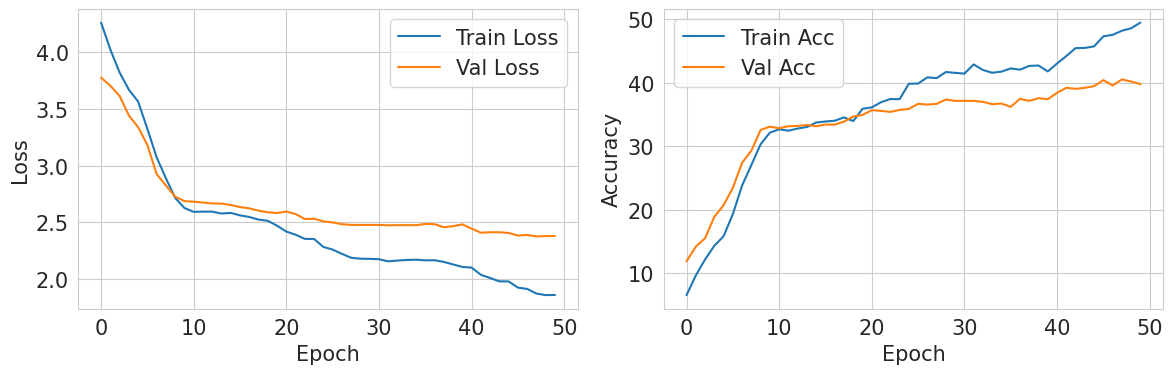

In [19]:
#---------------------------Обучение на сплите---------------------------

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    data_path = "/home/jupyter/datasphere/project/dl-2025-competition-1/data/train"
    file_paths, labels, classes = load_data(data_path)
    
    train_files, val_files, train_labels, val_labels = train_test_split(
        file_paths, labels, test_size=0.2, stratify=labels
    )
    
    train_dataset = CustomDataset(train_files, train_labels, train_transform)
    val_dataset = CustomDataset(val_files, val_labels, val_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
    
    model = ImprovedCNN(num_classes=len(classes)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    scheduler_plateau = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    scheduler_cosine = CosineAnnealingLR(optimizer, T_max=10)
    
    history = train_model(
        model, train_loader, val_loader, criterion, 
        optimizer, scheduler_cosine, device, num_epochs=50
    )
    
    plot_history(history)
    
    # model.load_state_dict(torch.load('best_model.pth'))
    
    # Тестирование (если есть тестовые метки)
    # test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    # print(f'Test Accuracy: {test_acc:.2f}%')

if __name__ == "__main__":
    main()

In [24]:
#---------------------------Обучение на всем трейне---------------------------

class CustomDataset(Dataset):
    def __init__(self, file_paths, labels=None, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.is_test = labels is None

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.file_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(image=img)['image']  

        if self.is_test:
            return img
        return img, self.labels[idx]

def load_data(data_path, is_test=False):
    if is_test:
        files = sorted([os.path.join(data_path, f) for f in os.listdir(data_path) 
                       if f.endswith(('.png', '.jpg', '.jpeg'))],
                      key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
        return files, None
    
    classes = sorted(os.listdir(data_path))
    file_paths = []
    labels = []
    
    for class_id, class_name in enumerate(classes):
        class_path = os.path.join(data_path, class_name)
        for img_name in os.listdir(class_path):
            file_paths.append(os.path.join(class_path, img_name))
            labels.append(class_id)
    
    return file_paths, labels, classes

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(ImprovedCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def train(model, train_loader, criterion, optimizer, device, scheduler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    if scheduler:
        scheduler.step()
    
    return running_loss / len(train_loader), 100. * correct / total

def evaluate(model, test_loader, device):
    model.eval()
    predictions = []
    file_ids = []
    
    with torch.no_grad():
        for inputs in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    
    return predictions

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    train_path = "/home/jupyter/datasphere/project/dl-2025-competition-1/data/train"
    train_files, train_labels, classes = load_data(train_path)
    
    test_path = "/home/jupyter/datasphere/project/dl-2025-competition-1/data/test"
    test_files, _ = load_data(test_path, is_test=True)
    
    train_dataset = CustomDataset(train_files, train_labels, train_transform)
    test_dataset = CustomDataset(test_files, transform=test_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
    
    model = ImprovedCNN(num_classes=len(classes)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    
    print("Training on full train dataset...")
    for epoch in range(50):  # 50 эпох
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device, scheduler)
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    
    print("Predicting on test dataset...")
    predictions = evaluate(model, test_loader, device)
    
    file_ids = [int(os.path.splitext(os.path.basename(f))[0]) for f in test_files]
    submission_df = pd.DataFrame({'id': file_ids, 'target': predictions})
    submission_df = submission_df.sort_values('id')
    submission_df.to_csv('submission.csv', index=False)
    print("Submission file saved as 'submission.csv'")
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'classes': classes,
        'model_architecture': ImprovedCNN
    }, 'full_model.pth')
    print("Model saved as 'full_model.pth'")

if __name__ == "__main__":
    main()

Training on full train dataset...


Training: 100%|██████████| 149/149 [00:04<00:00, 36.43it/s]


Epoch 1: Train Loss: 4.0307, Acc: 9.65%


Training: 100%|██████████| 149/149 [00:01<00:00, 113.74it/s]


Epoch 2: Train Loss: 3.4656, Acc: 17.59%


Training: 100%|██████████| 149/149 [00:01<00:00, 113.71it/s]


Epoch 3: Train Loss: 3.1338, Acc: 23.13%


Training: 100%|██████████| 149/149 [00:01<00:00, 112.71it/s]


Epoch 4: Train Loss: 2.8898, Acc: 28.37%


Training: 100%|██████████| 149/149 [00:01<00:00, 113.01it/s]


Epoch 5: Train Loss: 2.6871, Acc: 31.78%


Training: 100%|██████████| 149/149 [00:01<00:00, 115.05it/s]


Epoch 6: Train Loss: 2.5124, Acc: 35.46%


Training: 100%|██████████| 149/149 [00:01<00:00, 113.40it/s]


Epoch 7: Train Loss: 2.3678, Acc: 38.38%


Training: 100%|██████████| 149/149 [00:01<00:00, 113.54it/s]


Epoch 8: Train Loss: 2.2231, Acc: 41.58%


Training: 100%|██████████| 149/149 [00:01<00:00, 113.58it/s]


Epoch 9: Train Loss: 2.0965, Acc: 44.84%


Training: 100%|██████████| 149/149 [00:01<00:00, 114.68it/s]


Epoch 10: Train Loss: 1.9786, Acc: 47.09%


Training: 100%|██████████| 149/149 [00:01<00:00, 115.81it/s]


Epoch 11: Train Loss: 1.8932, Acc: 49.43%


Training: 100%|██████████| 149/149 [00:01<00:00, 112.32it/s]


Epoch 12: Train Loss: 1.7901, Acc: 51.58%


Training: 100%|██████████| 149/149 [00:01<00:00, 114.50it/s]


Epoch 13: Train Loss: 1.7118, Acc: 53.50%


Training: 100%|██████████| 149/149 [00:01<00:00, 113.06it/s]


Epoch 14: Train Loss: 1.6284, Acc: 55.10%


Training: 100%|██████████| 149/149 [00:01<00:00, 113.00it/s]


Epoch 15: Train Loss: 1.5664, Acc: 57.05%


Training: 100%|██████████| 149/149 [00:01<00:00, 113.21it/s]


Epoch 16: Train Loss: 1.5261, Acc: 58.09%


Training: 100%|██████████| 149/149 [00:01<00:00, 115.37it/s]


Epoch 17: Train Loss: 1.4753, Acc: 59.89%


Training: 100%|██████████| 149/149 [00:01<00:00, 112.42it/s]


Epoch 18: Train Loss: 1.4614, Acc: 59.76%


Training: 100%|██████████| 149/149 [00:01<00:00, 112.75it/s]


Epoch 19: Train Loss: 1.4191, Acc: 61.25%


Training: 100%|██████████| 149/149 [00:01<00:00, 111.86it/s]


Epoch 20: Train Loss: 1.4345, Acc: 60.86%


Training: 100%|██████████| 149/149 [00:01<00:00, 112.96it/s]


Epoch 21: Train Loss: 1.4226, Acc: 60.75%


Training: 100%|██████████| 149/149 [00:01<00:00, 115.01it/s]


Epoch 22: Train Loss: 1.4009, Acc: 61.81%


Training: 100%|██████████| 149/149 [00:01<00:00, 114.06it/s]


Epoch 23: Train Loss: 1.4190, Acc: 61.45%


Training: 100%|██████████| 149/149 [00:01<00:00, 113.42it/s]


Epoch 24: Train Loss: 1.4367, Acc: 60.47%


Training: 100%|██████████| 149/149 [00:01<00:00, 115.36it/s]


Epoch 25: Train Loss: 1.4085, Acc: 61.39%


Training: 100%|██████████| 149/149 [00:01<00:00, 114.67it/s]


Epoch 26: Train Loss: 1.4063, Acc: 61.37%


Training: 100%|██████████| 149/149 [00:01<00:00, 114.73it/s]


Epoch 27: Train Loss: 1.4201, Acc: 61.20%


Training: 100%|██████████| 149/149 [00:01<00:00, 113.79it/s]


Epoch 28: Train Loss: 1.4223, Acc: 60.30%


Training: 100%|██████████| 149/149 [00:01<00:00, 115.16it/s]


Epoch 29: Train Loss: 1.4197, Acc: 60.39%


Training: 100%|██████████| 149/149 [00:01<00:00, 113.35it/s]


Epoch 30: Train Loss: 1.4194, Acc: 59.80%


Training: 100%|██████████| 149/149 [00:01<00:00, 112.41it/s]


Epoch 31: Train Loss: 1.4253, Acc: 60.01%


Training: 100%|██████████| 149/149 [00:01<00:00, 113.69it/s]


Epoch 32: Train Loss: 1.4285, Acc: 60.00%


Training: 100%|██████████| 149/149 [00:01<00:00, 113.82it/s]


Epoch 33: Train Loss: 1.4056, Acc: 59.83%


Training: 100%|██████████| 149/149 [00:01<00:00, 114.01it/s]


Epoch 34: Train Loss: 1.4232, Acc: 59.96%


Training: 100%|██████████| 149/149 [00:01<00:00, 113.63it/s]


Epoch 35: Train Loss: 1.4209, Acc: 59.68%


Training: 100%|██████████| 149/149 [00:01<00:00, 114.36it/s]


Epoch 36: Train Loss: 1.3961, Acc: 59.95%


Training: 100%|██████████| 149/149 [00:01<00:00, 114.83it/s]


Epoch 37: Train Loss: 1.3659, Acc: 60.98%


Training: 100%|██████████| 149/149 [00:01<00:00, 111.89it/s]


Epoch 38: Train Loss: 1.3574, Acc: 61.03%


Training: 100%|██████████| 149/149 [00:01<00:00, 112.26it/s]


Epoch 39: Train Loss: 1.2964, Acc: 62.58%


Training: 100%|██████████| 149/149 [00:01<00:00, 112.87it/s]


Epoch 40: Train Loss: 1.2536, Acc: 63.10%


Training: 100%|██████████| 149/149 [00:01<00:00, 115.25it/s]


Epoch 41: Train Loss: 1.2524, Acc: 63.73%


Training: 100%|██████████| 149/149 [00:01<00:00, 112.89it/s]


Epoch 42: Train Loss: 1.1890, Acc: 64.64%


Training: 100%|██████████| 149/149 [00:01<00:00, 114.27it/s]


Epoch 43: Train Loss: 1.1355, Acc: 66.91%


Training: 100%|██████████| 149/149 [00:01<00:00, 114.41it/s]


Epoch 44: Train Loss: 1.0774, Acc: 67.70%


Training: 100%|██████████| 149/149 [00:01<00:00, 113.51it/s]


Epoch 45: Train Loss: 1.0244, Acc: 69.97%


Training: 100%|██████████| 149/149 [00:01<00:00, 113.65it/s]


Epoch 46: Train Loss: 0.9766, Acc: 70.81%


Training: 100%|██████████| 149/149 [00:01<00:00, 114.19it/s]


Epoch 47: Train Loss: 0.9384, Acc: 71.79%


Training: 100%|██████████| 149/149 [00:01<00:00, 113.68it/s]


Epoch 48: Train Loss: 0.8715, Acc: 74.40%


Training: 100%|██████████| 149/149 [00:01<00:00, 113.68it/s]


Epoch 49: Train Loss: 0.8311, Acc: 75.65%


Training: 100%|██████████| 149/149 [00:01<00:00, 112.08it/s]


Epoch 50: Train Loss: 0.7721, Acc: 77.06%
Predicting on test dataset...


Testing: 100%|██████████| 61/61 [00:02<00:00, 27.90it/s]


Submission file saved as 'submission.csv'
Model saved as 'full_model.pth'


In [28]:
#---------------------------Обучение на всем трейне---------------------------

class CustomDataset(Dataset):
    def __init__(self, file_paths, labels=None, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.is_test = labels is None

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.file_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(image=img)['image']  

        if self.is_test:
            return img
        return img, self.labels[idx]

def load_data(data_path, is_test=False):
    if is_test:
        files = sorted([os.path.join(data_path, f) for f in os.listdir(data_path) 
                       if f.endswith(('.png', '.jpg', '.jpeg'))],
                      key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
        return files, None
    
    classes = sorted(os.listdir(data_path))
    file_paths = []
    labels = []
    
    for class_id, class_name in enumerate(classes):
        class_path = os.path.join(data_path, class_name)
        for img_name in os.listdir(class_path):
            file_paths.append(os.path.join(class_path, img_name))
            labels.append(class_id)
    
    return file_paths, labels, classes

class SimpleNet(torch.nn.Module):
    def __init__(self, num_classes=100, dropout=0.4):
        super().__init__()
        
        self.batch_norm0 = torch.nn.BatchNorm2d(3)  
        
        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2)
        
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            self.relu,
            self.maxpool,
        )
        self.batch_norm1 = torch.nn.BatchNorm2d(32)
        
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            self.relu,
            self.maxpool,
        )
        self.batch_norm2 = torch.nn.BatchNorm2d(64)
        
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            self.relu,
            self.maxpool,
        )
        self.batch_norm3 = torch.nn.BatchNorm2d(128)
        
        self.linear1 = torch.nn.Linear(in_features=128 * 4 * 4, out_features=256)  
        self.linear2 = torch.nn.Linear(in_features=256, out_features=128)
        
        self.output = torch.nn.Linear(in_features=128, out_features=num_classes)
        self.dropout = torch.nn.Dropout(p=dropout)
        
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        x = self.batch_norm0(x)
        
        x = self.conv1(x)
        x = self.batch_norm1(x)
        
        x = self.conv2(x)
        x = self.batch_norm2(x)
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))
        x = self.dropout(x)
        
        return self.output(x)

    def forward(self, images, target=None):
        output = self._forward(images)
        
        if target is not None:
            loss = self.loss_func(output, target)
            
            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long())
            
            return loss
        
        return output

    def get_accuracy(self, reset=False):
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy.item() if hasattr(self, 'accuracy') else 0.0

def train(model, train_loader, criterion, optimizer, device, scheduler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    if scheduler:
        scheduler.step()
    
    return running_loss / len(train_loader), 100. * correct / total

def evaluate(model, test_loader, device):
    model.eval()
    predictions = []
    file_ids = []
    
    with torch.no_grad():
        for inputs in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    
    return predictions

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    train_path = "/home/jupyter/datasphere/project/dl-2025-competition-1/data/train"
    train_files, train_labels, classes = load_data(train_path)
    
    test_path = "/home/jupyter/datasphere/project/dl-2025-competition-1/data/test"
    test_files, _ = load_data(test_path, is_test=True)
    
    train_dataset = CustomDataset(train_files, train_labels, train_transform)
    test_dataset = CustomDataset(test_files, transform=test_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4)
    
    model = SimpleNet(num_classes=len(classes)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    
    print("Training on full train dataset...")
    for epoch in range(100):  # 50 эпох
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device, scheduler)
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    
    print("Predicting on test dataset...")
    predictions = evaluate(model, test_loader, device)
    
    file_ids = [int(os.path.splitext(os.path.basename(f))[0]) for f in test_files]
    submission_df = pd.DataFrame({'id': file_ids, 'target': predictions})
    submission_df = submission_df.sort_values('id')
    submission_df.to_csv('submission.csv', index=False)
    print("Submission file saved as 'submission.csv'")
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'classes': classes,
        'model_architecture': ImprovedCNN
    }, 'full_model.pth')
    print("Model saved as 'full_model.pth'")

if __name__ == "__main__":
    main()

Training on full train dataset...


Training: 100%|██████████| 19/19 [00:02<00:00,  6.61it/s]


Epoch 1: Train Loss: 4.4150, Acc: 4.91%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.70it/s]


Epoch 2: Train Loss: 4.0340, Acc: 9.94%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.01it/s]


Epoch 3: Train Loss: 3.7697, Acc: 13.53%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.18it/s]


Epoch 4: Train Loss: 3.5661, Acc: 16.36%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.10it/s]


Epoch 5: Train Loss: 3.3809, Acc: 19.54%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.28it/s]


Epoch 6: Train Loss: 3.2243, Acc: 22.09%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.33it/s]


Epoch 7: Train Loss: 3.1282, Acc: 23.65%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.02it/s]


Epoch 8: Train Loss: 3.0102, Acc: 26.09%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.87it/s]


Epoch 9: Train Loss: 2.9095, Acc: 27.48%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.14it/s]


Epoch 10: Train Loss: 2.8073, Acc: 29.22%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.33it/s]


Epoch 11: Train Loss: 2.7277, Acc: 30.90%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.27it/s]


Epoch 12: Train Loss: 2.6686, Acc: 32.42%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.48it/s]


Epoch 13: Train Loss: 2.5841, Acc: 33.86%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.20it/s]


Epoch 14: Train Loss: 2.5571, Acc: 34.36%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.05it/s]


Epoch 15: Train Loss: 2.5282, Acc: 35.88%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.90it/s]


Epoch 16: Train Loss: 2.4817, Acc: 36.24%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.93it/s]


Epoch 17: Train Loss: 2.4638, Acc: 36.42%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.06it/s]


Epoch 18: Train Loss: 2.4449, Acc: 36.39%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.85it/s]


Epoch 19: Train Loss: 2.4379, Acc: 37.03%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.14it/s]


Epoch 20: Train Loss: 2.4124, Acc: 36.93%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.25it/s]


Epoch 21: Train Loss: 2.4096, Acc: 37.98%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.82it/s]


Epoch 22: Train Loss: 2.4143, Acc: 36.62%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.97it/s]


Epoch 23: Train Loss: 2.4254, Acc: 36.90%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.28it/s]


Epoch 24: Train Loss: 2.4075, Acc: 37.68%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.39it/s]


Epoch 25: Train Loss: 2.4085, Acc: 37.20%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.62it/s]


Epoch 26: Train Loss: 2.3855, Acc: 37.92%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.98it/s]


Epoch 27: Train Loss: 2.3924, Acc: 37.17%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.72it/s]


Epoch 28: Train Loss: 2.3811, Acc: 37.91%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.27it/s]


Epoch 29: Train Loss: 2.3407, Acc: 38.49%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.14it/s]


Epoch 30: Train Loss: 2.3348, Acc: 38.84%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.50it/s]


Epoch 31: Train Loss: 2.3033, Acc: 39.30%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.14it/s]


Epoch 32: Train Loss: 2.2702, Acc: 39.99%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.61it/s]


Epoch 33: Train Loss: 2.2569, Acc: 40.60%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.29it/s]


Epoch 34: Train Loss: 2.2152, Acc: 41.21%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.41it/s]


Epoch 35: Train Loss: 2.1945, Acc: 41.39%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.65it/s]


Epoch 36: Train Loss: 2.1375, Acc: 42.61%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.10it/s]


Epoch 37: Train Loss: 2.1304, Acc: 42.78%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.29it/s]


Epoch 38: Train Loss: 2.0904, Acc: 43.18%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.90it/s]


Epoch 39: Train Loss: 2.0267, Acc: 45.14%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.03it/s]


Epoch 40: Train Loss: 1.9606, Acc: 46.25%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.84it/s]


Epoch 41: Train Loss: 1.9374, Acc: 47.13%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.57it/s]


Epoch 42: Train Loss: 1.8885, Acc: 47.89%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.27it/s]


Epoch 43: Train Loss: 1.8385, Acc: 49.91%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.25it/s]


Epoch 44: Train Loss: 1.8052, Acc: 50.12%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.12it/s]


Epoch 45: Train Loss: 1.7425, Acc: 51.65%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.03it/s]


Epoch 46: Train Loss: 1.6919, Acc: 53.13%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.84it/s]


Epoch 47: Train Loss: 1.6499, Acc: 53.61%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.31it/s]


Epoch 48: Train Loss: 1.5810, Acc: 55.33%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.12it/s]


Epoch 49: Train Loss: 1.5395, Acc: 56.77%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.73it/s]


Epoch 50: Train Loss: 1.4820, Acc: 57.52%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.93it/s]


Epoch 51: Train Loss: 1.4488, Acc: 58.58%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.24it/s]


Epoch 52: Train Loss: 1.3937, Acc: 60.04%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.55it/s]


Epoch 53: Train Loss: 1.3506, Acc: 61.61%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.68it/s]


Epoch 54: Train Loss: 1.3189, Acc: 62.19%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.57it/s]


Epoch 55: Train Loss: 1.2823, Acc: 63.58%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.49it/s]


Epoch 56: Train Loss: 1.2648, Acc: 63.49%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.46it/s]


Epoch 57: Train Loss: 1.2325, Acc: 64.46%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.12it/s]


Epoch 58: Train Loss: 1.2360, Acc: 64.06%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.39it/s]


Epoch 59: Train Loss: 1.2403, Acc: 64.17%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.54it/s]


Epoch 60: Train Loss: 1.2134, Acc: 64.69%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.00it/s]


Epoch 61: Train Loss: 1.2194, Acc: 64.61%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.40it/s]


Epoch 62: Train Loss: 1.2227, Acc: 64.85%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.88it/s]


Epoch 63: Train Loss: 1.2161, Acc: 64.87%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.77it/s]


Epoch 64: Train Loss: 1.2096, Acc: 65.67%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.29it/s]


Epoch 65: Train Loss: 1.2304, Acc: 64.05%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.67it/s]


Epoch 66: Train Loss: 1.2140, Acc: 65.01%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.44it/s]


Epoch 67: Train Loss: 1.2137, Acc: 64.66%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.91it/s]


Epoch 68: Train Loss: 1.2177, Acc: 64.72%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.34it/s]


Epoch 69: Train Loss: 1.2191, Acc: 64.58%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.09it/s]


Epoch 70: Train Loss: 1.2187, Acc: 64.62%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.79it/s]


Epoch 71: Train Loss: 1.2225, Acc: 65.04%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.58it/s]


Epoch 72: Train Loss: 1.2346, Acc: 64.44%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.23it/s]


Epoch 73: Train Loss: 1.2533, Acc: 64.03%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.53it/s]


Epoch 74: Train Loss: 1.2539, Acc: 63.63%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.60it/s]


Epoch 75: Train Loss: 1.2695, Acc: 63.31%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.12it/s]


Epoch 76: Train Loss: 1.2483, Acc: 63.96%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.97it/s]


Epoch 77: Train Loss: 1.2591, Acc: 64.25%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.08it/s]


Epoch 78: Train Loss: 1.2356, Acc: 63.65%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.63it/s]


Epoch 79: Train Loss: 1.2354, Acc: 64.51%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.86it/s]


Epoch 80: Train Loss: 1.2381, Acc: 64.09%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.77it/s]


Epoch 81: Train Loss: 1.2363, Acc: 64.68%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.61it/s]


Epoch 82: Train Loss: 1.2166, Acc: 64.37%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.76it/s]


Epoch 83: Train Loss: 1.1687, Acc: 65.95%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.37it/s]


Epoch 84: Train Loss: 1.1621, Acc: 66.41%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.68it/s]


Epoch 85: Train Loss: 1.1315, Acc: 67.25%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.59it/s]


Epoch 86: Train Loss: 1.0906, Acc: 67.77%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.38it/s]


Epoch 87: Train Loss: 1.0556, Acc: 68.75%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.63it/s]


Epoch 88: Train Loss: 1.0319, Acc: 69.85%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.54it/s]


Epoch 89: Train Loss: 1.0152, Acc: 70.07%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.24it/s]


Epoch 90: Train Loss: 0.9429, Acc: 72.44%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.58it/s]


Epoch 91: Train Loss: 0.9309, Acc: 72.73%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.69it/s]


Epoch 92: Train Loss: 0.8616, Acc: 74.02%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.70it/s]


Epoch 93: Train Loss: 0.8567, Acc: 74.89%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.03it/s]


Epoch 94: Train Loss: 0.8398, Acc: 75.07%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.70it/s]


Epoch 95: Train Loss: 0.8128, Acc: 76.04%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.64it/s]


Epoch 96: Train Loss: 0.8131, Acc: 75.86%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.77it/s]


Epoch 97: Train Loss: 0.7842, Acc: 77.09%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.73it/s]


Epoch 98: Train Loss: 0.7684, Acc: 76.85%


Training: 100%|██████████| 19/19 [00:00<00:00, 20.37it/s]


Epoch 99: Train Loss: 0.7752, Acc: 77.44%


Training: 100%|██████████| 19/19 [00:00<00:00, 19.94it/s]


Epoch 100: Train Loss: 0.7506, Acc: 77.83%
Predicting on test dataset...


Testing: 100%|██████████| 8/8 [00:02<00:00,  3.76it/s]

Submission file saved as 'submission.csv'
Model saved as 'full_model.pth'


In [29]:
#---------------------------Обучение на всем трейне---------------------------

class CustomDataset(Dataset):
    def __init__(self, file_paths, labels=None, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.is_test = labels is None

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.file_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(image=img)['image']  

        if self.is_test:
            return img
        return img, self.labels[idx]

def load_data(data_path, is_test=False):
    if is_test:
        files = sorted([os.path.join(data_path, f) for f in os.listdir(data_path) 
                       if f.endswith(('.png', '.jpg', '.jpeg'))],
                      key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
        return files, None
    
    classes = sorted(os.listdir(data_path))
    file_paths = []
    labels = []
    
    for class_id, class_name in enumerate(classes):
        class_path = os.path.join(data_path, class_name)
        for img_name in os.listdir(class_path):
            file_paths.append(os.path.join(class_path, img_name))
            labels.append(class_id)
    
    return file_paths, labels, classes


class CustomCNN_1(nn.Module):
    def __init__(self, num_classes=100, pretrained=False, pretrained_model_name='resnet18'):
        super().__init__()
        
        if pretrained:
            self._load_pretrained_backbone(pretrained_model_name)
            for param in self.features.parameters():
                param.requires_grad = False
        else:
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(2),
                
                nn.Conv2d(64, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.MaxPool2d(2),
                
                nn.Conv2d(128, 256, 3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(2),
                
                nn.Conv2d(256, 512, 3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.AdaptiveAvgPool2d(1)
            )
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
        if pretrained and pretrained_model_name is None:
            self._init_pretrained_weights()
    
    def _load_pretrained_backbone(self, model_name):
        """Загружает предобученную модель"""
        pretrained_models = {
            'resnet18': models.resnet18,
            'resnet34': models.resnet34,
            'resnet50': models.resnet50
        }
        
        if model_name not in pretrained_models:
            raise ValueError(f"Доступные модели: {list(pretrained_models.keys())}")
            
        model = pretrained_models[model_name](pretrained=True)
        self.features = nn.Sequential(*list(model.children())[:-2])  
        
        # Адаптация размеров
        if model_name.startswith('resnet50'):
            self.classifier[0] = nn.Linear(2048, 256)  
    
    def _init_pretrained_weights(self):
        """Инициализация весов в стиле предобученных моделей"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

def train(model, train_loader, criterion, optimizer, device, scheduler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    if scheduler:
        scheduler.step()
    
    return running_loss / len(train_loader), 100. * correct / total

def evaluate(model, test_loader, device):
    model.eval()
    predictions = []
    file_ids = []
    
    with torch.no_grad():
        for inputs in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    
    return predictions

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    train_path = "/home/jupyter/datasphere/project/dl-2025-competition-1/data/train"
    train_files, train_labels, classes = load_data(train_path)
    
    test_path = "/home/jupyter/datasphere/project/dl-2025-competition-1/data/test"
    test_files, _ = load_data(test_path, is_test=True)
    
    train_dataset = CustomDataset(train_files, train_labels, train_transform)
    test_dataset = CustomDataset(test_files, transform=test_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)
    
    model = CustomCNN_1(num_classes=len(classes)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    
    print("Training on full train dataset...")
    for epoch in range(100):  # 100 эпох
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device, scheduler)
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    
    print("Predicting on test dataset...")
    predictions = evaluate(model, test_loader, device)
    
    file_ids = [int(os.path.splitext(os.path.basename(f))[0]) for f in test_files]
    submission_df = pd.DataFrame({'id': file_ids, 'target': predictions})
    submission_df = submission_df.sort_values('id')
    submission_df.to_csv('submission.csv', index=False)
    print("Submission file saved as 'submission.csv'")
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'classes': classes,
        'model_architecture': ImprovedCNN
    }, 'full_model.pth')
    print("Model saved as 'full_model.pth'")

if __name__ == "__main__":
    main()

Training on full train dataset...


Training: 100%|██████████| 75/75 [00:03<00:00, 24.42it/s]


Epoch 1: Train Loss: 4.2303, Acc: 5.83%


Training: 100%|██████████| 75/75 [00:00<00:00, 79.71it/s]


Epoch 2: Train Loss: 3.8590, Acc: 10.13%


Training: 100%|██████████| 75/75 [00:00<00:00, 79.02it/s]


Epoch 3: Train Loss: 3.6290, Acc: 12.99%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.94it/s]


Epoch 4: Train Loss: 3.4640, Acc: 16.41%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.97it/s]


Epoch 5: Train Loss: 3.3017, Acc: 19.13%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.25it/s]


Epoch 6: Train Loss: 3.1467, Acc: 21.90%


Training: 100%|██████████| 75/75 [00:00<00:00, 76.81it/s]


Epoch 7: Train Loss: 3.0254, Acc: 24.57%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.83it/s]


Epoch 8: Train Loss: 2.9213, Acc: 25.58%


Training: 100%|██████████| 75/75 [00:00<00:00, 79.25it/s]


Epoch 9: Train Loss: 2.7896, Acc: 28.92%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.10it/s]


Epoch 10: Train Loss: 2.6886, Acc: 30.75%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.06it/s]


Epoch 11: Train Loss: 2.5840, Acc: 32.67%


Training: 100%|██████████| 75/75 [00:00<00:00, 76.76it/s]


Epoch 12: Train Loss: 2.4969, Acc: 34.72%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.79it/s]


Epoch 13: Train Loss: 2.3984, Acc: 36.51%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.71it/s]


Epoch 14: Train Loss: 2.3229, Acc: 38.39%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.84it/s]


Epoch 15: Train Loss: 2.2557, Acc: 40.22%


Training: 100%|██████████| 75/75 [00:00<00:00, 76.64it/s]


Epoch 16: Train Loss: 2.1802, Acc: 41.39%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.97it/s]


Epoch 17: Train Loss: 2.1323, Acc: 41.93%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.93it/s]


Epoch 18: Train Loss: 2.0926, Acc: 43.64%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.61it/s]


Epoch 19: Train Loss: 2.0687, Acc: 44.24%


Training: 100%|██████████| 75/75 [00:00<00:00, 76.30it/s]


Epoch 20: Train Loss: 2.0560, Acc: 44.10%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.55it/s]


Epoch 21: Train Loss: 2.0360, Acc: 44.25%


Training: 100%|██████████| 75/75 [00:00<00:00, 76.16it/s]


Epoch 22: Train Loss: 2.0383, Acc: 44.20%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.95it/s]


Epoch 23: Train Loss: 2.0336, Acc: 44.35%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.01it/s]


Epoch 24: Train Loss: 2.0610, Acc: 43.79%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.13it/s]


Epoch 25: Train Loss: 2.0621, Acc: 43.14%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.62it/s]


Epoch 26: Train Loss: 2.0565, Acc: 43.45%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.21it/s]


Epoch 27: Train Loss: 2.0572, Acc: 43.76%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.91it/s]


Epoch 28: Train Loss: 2.0716, Acc: 42.72%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.77it/s]


Epoch 29: Train Loss: 2.0740, Acc: 43.08%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.23it/s]


Epoch 30: Train Loss: 2.0520, Acc: 44.23%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.29it/s]


Epoch 31: Train Loss: 2.0430, Acc: 44.12%


Training: 100%|██████████| 75/75 [00:00<00:00, 76.97it/s]


Epoch 32: Train Loss: 2.0612, Acc: 43.88%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.70it/s]


Epoch 33: Train Loss: 2.0540, Acc: 43.60%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.74it/s]


Epoch 34: Train Loss: 2.0450, Acc: 44.20%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.56it/s]


Epoch 35: Train Loss: 1.9948, Acc: 45.62%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.10it/s]


Epoch 36: Train Loss: 1.9904, Acc: 45.06%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.91it/s]


Epoch 37: Train Loss: 1.9372, Acc: 46.33%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.86it/s]


Epoch 38: Train Loss: 1.9053, Acc: 47.13%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.41it/s]


Epoch 39: Train Loss: 1.8872, Acc: 47.15%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.60it/s]


Epoch 40: Train Loss: 1.8222, Acc: 48.83%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.27it/s]


Epoch 41: Train Loss: 1.7760, Acc: 49.91%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.91it/s]


Epoch 42: Train Loss: 1.7577, Acc: 50.20%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.82it/s]


Epoch 43: Train Loss: 1.6967, Acc: 51.49%


Training: 100%|██████████| 75/75 [00:00<00:00, 75.04it/s]


Epoch 44: Train Loss: 1.6195, Acc: 54.21%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.50it/s]


Epoch 45: Train Loss: 1.5722, Acc: 54.76%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.20it/s]


Epoch 46: Train Loss: 1.5034, Acc: 56.83%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.46it/s]


Epoch 47: Train Loss: 1.4440, Acc: 58.45%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.71it/s]


Epoch 48: Train Loss: 1.3666, Acc: 59.93%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.37it/s]


Epoch 49: Train Loss: 1.2786, Acc: 62.09%


Training: 100%|██████████| 75/75 [00:00<00:00, 80.03it/s]


Epoch 50: Train Loss: 1.2345, Acc: 63.65%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.96it/s]


Epoch 51: Train Loss: 1.1441, Acc: 65.96%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.50it/s]


Epoch 52: Train Loss: 1.0825, Acc: 67.91%


Training: 100%|██████████| 75/75 [00:00<00:00, 76.96it/s]


Epoch 53: Train Loss: 1.0307, Acc: 69.40%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.56it/s]


Epoch 54: Train Loss: 0.9662, Acc: 71.39%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.69it/s]


Epoch 55: Train Loss: 0.9131, Acc: 72.79%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.81it/s]


Epoch 56: Train Loss: 0.8469, Acc: 74.46%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.95it/s]


Epoch 57: Train Loss: 0.8337, Acc: 75.47%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.95it/s]


Epoch 58: Train Loss: 0.8141, Acc: 75.51%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.08it/s]


Epoch 59: Train Loss: 0.7899, Acc: 76.44%


Training: 100%|██████████| 75/75 [00:01<00:00, 61.95it/s]


Epoch 60: Train Loss: 0.7716, Acc: 77.32%


Training: 100%|██████████| 75/75 [00:00<00:00, 76.92it/s]


Epoch 61: Train Loss: 0.7755, Acc: 77.15%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.83it/s]


Epoch 62: Train Loss: 0.7741, Acc: 77.31%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.67it/s]


Epoch 63: Train Loss: 0.7862, Acc: 76.86%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.28it/s]


Epoch 64: Train Loss: 0.7839, Acc: 76.76%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.70it/s]


Epoch 65: Train Loss: 0.7787, Acc: 77.23%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.00it/s]


Epoch 66: Train Loss: 0.8004, Acc: 75.79%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.54it/s]


Epoch 67: Train Loss: 0.8278, Acc: 75.03%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.76it/s]


Epoch 68: Train Loss: 0.8307, Acc: 74.70%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.31it/s]


Epoch 69: Train Loss: 0.8731, Acc: 73.95%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.36it/s]


Epoch 70: Train Loss: 0.8985, Acc: 72.86%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.58it/s]


Epoch 71: Train Loss: 0.9283, Acc: 72.46%


Training: 100%|██████████| 75/75 [00:00<00:00, 76.78it/s]


Epoch 72: Train Loss: 0.9695, Acc: 70.93%


Training: 100%|██████████| 75/75 [00:00<00:00, 76.98it/s]


Epoch 73: Train Loss: 0.9945, Acc: 70.07%


Training: 100%|██████████| 75/75 [00:00<00:00, 79.12it/s]


Epoch 74: Train Loss: 1.0004, Acc: 69.72%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.31it/s]


Epoch 75: Train Loss: 1.0387, Acc: 68.31%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.56it/s]


Epoch 76: Train Loss: 1.0376, Acc: 68.54%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.18it/s]


Epoch 77: Train Loss: 1.0352, Acc: 68.58%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.31it/s]


Epoch 78: Train Loss: 1.0491, Acc: 68.34%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.91it/s]


Epoch 79: Train Loss: 1.0498, Acc: 68.98%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.47it/s]


Epoch 80: Train Loss: 1.0188, Acc: 69.52%


Training: 100%|██████████| 75/75 [00:00<00:00, 79.00it/s]


Epoch 81: Train Loss: 0.9997, Acc: 69.62%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.90it/s]


Epoch 82: Train Loss: 0.9395, Acc: 71.64%


Training: 100%|██████████| 75/75 [00:00<00:00, 76.48it/s]


Epoch 83: Train Loss: 0.9267, Acc: 71.16%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.50it/s]


Epoch 84: Train Loss: 0.8806, Acc: 72.77%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.55it/s]


Epoch 85: Train Loss: 0.8499, Acc: 73.92%


Training: 100%|██████████| 75/75 [00:00<00:00, 79.10it/s]


Epoch 86: Train Loss: 0.7701, Acc: 76.51%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.04it/s]


Epoch 87: Train Loss: 0.7460, Acc: 77.50%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.98it/s]


Epoch 88: Train Loss: 0.6713, Acc: 79.27%


Training: 100%|██████████| 75/75 [00:00<00:00, 79.54it/s]


Epoch 89: Train Loss: 0.6256, Acc: 81.11%


Training: 100%|██████████| 75/75 [00:00<00:00, 79.70it/s]


Epoch 90: Train Loss: 0.5730, Acc: 82.48%


Training: 100%|██████████| 75/75 [00:00<00:00, 79.29it/s]


Epoch 91: Train Loss: 0.5416, Acc: 84.06%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.98it/s]


Epoch 92: Train Loss: 0.4923, Acc: 84.88%


Training: 100%|██████████| 75/75 [00:00<00:00, 79.85it/s]


Epoch 93: Train Loss: 0.4521, Acc: 86.21%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.77it/s]


Epoch 94: Train Loss: 0.4179, Acc: 87.82%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.18it/s]


Epoch 95: Train Loss: 0.3983, Acc: 88.32%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.06it/s]


Epoch 96: Train Loss: 0.3589, Acc: 89.62%


Training: 100%|██████████| 75/75 [00:00<00:00, 79.04it/s]


Epoch 97: Train Loss: 0.3444, Acc: 89.96%


Training: 100%|██████████| 75/75 [00:00<00:00, 79.67it/s]


Epoch 98: Train Loss: 0.3238, Acc: 90.64%


Training: 100%|██████████| 75/75 [00:00<00:00, 78.22it/s]


Epoch 99: Train Loss: 0.3185, Acc: 90.87%


Training: 100%|██████████| 75/75 [00:00<00:00, 77.77it/s]


Epoch 100: Train Loss: 0.3214, Acc: 90.66%
Predicting on test dataset...


Testing: 100%|██████████| 31/31 [00:02<00:00, 14.24it/s]


Submission file saved as 'submission.csv'
Model saved as 'full_model.pth'


In [30]:
#---------------------------Обучение на всем трейне---------------------------

class CustomDataset(Dataset):
    def __init__(self, file_paths, labels=None, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.is_test = labels is None

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.file_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(image=img)['image']  

        if self.is_test:
            return img
        return img, self.labels[idx]

def load_data(data_path, is_test=False):
    if is_test:
        files = sorted([os.path.join(data_path, f) for f in os.listdir(data_path) 
                       if f.endswith(('.png', '.jpg', '.jpeg'))],
                      key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
        return files, None
    
    classes = sorted(os.listdir(data_path))
    file_paths = []
    labels = []
    
    for class_id, class_name in enumerate(classes):
        class_path = os.path.join(data_path, class_name)
        for img_name in os.listdir(class_path):
            file_paths.append(os.path.join(class_path, img_name))
            labels.append(class_id)
    
    return file_paths, labels, classes


class CVAE(nn.Module):
    def __init__(self, latent_dim=100, num_classes=100, img_channels=3, img_size=64):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.img_size = img_size
        self.img_channels = img_channels

        self.encoder_out_size = 512 * (img_size // 16) * (img_size // 16)

        self.encoder_conv = nn.Sequential(
            nn.Conv2d(img_channels + num_classes, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.encoder_fc_mu = nn.Linear(self.encoder_out_size, latent_dim)
        self.encoder_fc_logvar = nn.Linear(self.encoder_out_size, latent_dim)


        self.decoder_fc = nn.Linear(latent_dim + num_classes, self.encoder_out_size)
        
        self.decoder_deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x, labels):
        label_onehot = F.one_hot(labels, num_classes=self.num_classes).float()
        label_map = label_onehot.view(-1, self.num_classes, 1, 1)
        label_map = label_map.expand(-1, -1, x.size(2), x.size(3))
        
        x_cond = torch.cat([x, label_map], dim=1)
        
        h = self.encoder_conv(x_cond)
        h = h.view(h.size(0), -1)
        mu = self.encoder_fc_mu(h)
        logvar = self.encoder_fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, labels):
        label_onehot = F.one_hot(labels, num_classes=self.num_classes).float()
        z_cond = torch.cat([z, label_onehot], dim=1)
        
        h = self.decoder_fc(z_cond)
        h = h.view(h.size(0), 512, self.img_size // 16, self.img_size // 16)
        x_recon = self.decoder_deconv(h)
        return x_recon

    def forward(self, x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, labels)
        return x_recon, mu, logvar

    def sample(self, num_samples, labels, device):
        """Генерация новых изображений"""
        z = torch.randn(num_samples, self.latent_dim).to(device)
        label_onehot = F.one_hot(labels, num_classes=self.num_classes).float().to(device)
        z_cond = torch.cat([z, label_onehot], dim=1)
        return self.decode(z, labels)

def train(model, train_loader, criterion, optimizer, device, scheduler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    if scheduler:
        scheduler.step()
    
    return running_loss / len(train_loader), 100. * correct / total

def evaluate(model, test_loader, device):
    model.eval()
    predictions = []
    file_ids = []
    
    with torch.no_grad():
        for inputs in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    
    return predictions

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    train_path = "/home/jupyter/datasphere/project/dl-2025-competition-1/data/train"
    train_files, train_labels, classes = load_data(train_path)
    
    test_path = "/home/jupyter/datasphere/project/dl-2025-competition-1/data/test"
    test_files, _ = load_data(test_path, is_test=True)
    
    train_dataset = CustomDataset(train_files, train_labels, train_transform)
    test_dataset = CustomDataset(test_files, transform=test_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False, num_workers=4)
    
    model = CustomCNN_1(num_classes=len(classes)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    
    print("Training on full train dataset...")
    for epoch in range(100):  # 100 эпох
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device, scheduler)
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    
    print("Predicting on test dataset...")
    predictions = evaluate(model, test_loader, device)
    
    file_ids = [int(os.path.splitext(os.path.basename(f))[0]) for f in test_files]
    submission_df = pd.DataFrame({'id': file_ids, 'target': predictions})
    submission_df = submission_df.sort_values('id')
    submission_df.to_csv('submission.csv', index=False)
    print("Submission file saved as 'submission.csv'")
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'classes': classes,
        'model_architecture': ImprovedCNN
    }, 'full_model.pth')
    print("Model saved as 'full_model.pth'")

if __name__ == "__main__":
    main()

Training on full train dataset...


Training: 100%|██████████| 191/191 [00:02<00:00, 66.59it/s]


Epoch 1: Train Loss: 4.2253, Acc: 6.06%


Training: 100%|██████████| 191/191 [00:01<00:00, 156.73it/s]


Epoch 2: Train Loss: 3.8819, Acc: 9.44%


Training: 100%|██████████| 191/191 [00:01<00:00, 152.25it/s]


Epoch 3: Train Loss: 3.7006, Acc: 11.99%


Training: 100%|██████████| 191/191 [00:01<00:00, 156.47it/s]


Epoch 4: Train Loss: 3.5407, Acc: 13.94%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.57it/s]


Epoch 5: Train Loss: 3.4181, Acc: 16.66%


Training: 100%|██████████| 191/191 [00:01<00:00, 157.91it/s]


Epoch 6: Train Loss: 3.3034, Acc: 18.75%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.20it/s]


Epoch 7: Train Loss: 3.1604, Acc: 21.28%


Training: 100%|██████████| 191/191 [00:01<00:00, 154.78it/s]


Epoch 8: Train Loss: 3.0629, Acc: 23.06%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.88it/s]


Epoch 9: Train Loss: 2.9442, Acc: 24.84%


Training: 100%|██████████| 191/191 [00:01<00:00, 153.40it/s]


Epoch 10: Train Loss: 2.8576, Acc: 27.16%


Training: 100%|██████████| 191/191 [00:01<00:00, 156.30it/s]


Epoch 11: Train Loss: 2.7605, Acc: 28.60%


Training: 100%|██████████| 191/191 [00:01<00:00, 156.64it/s]


Epoch 12: Train Loss: 2.6639, Acc: 30.76%


Training: 100%|██████████| 191/191 [00:01<00:00, 154.88it/s]


Epoch 13: Train Loss: 2.5708, Acc: 32.73%


Training: 100%|██████████| 191/191 [00:01<00:00, 154.13it/s]


Epoch 14: Train Loss: 2.4908, Acc: 34.04%


Training: 100%|██████████| 191/191 [00:01<00:00, 156.66it/s]


Epoch 15: Train Loss: 2.4339, Acc: 35.84%


Training: 100%|██████████| 191/191 [00:01<00:00, 157.86it/s]


Epoch 16: Train Loss: 2.3692, Acc: 37.07%


Training: 100%|██████████| 191/191 [00:01<00:00, 158.08it/s]


Epoch 17: Train Loss: 2.2936, Acc: 38.37%


Training: 100%|██████████| 191/191 [00:01<00:00, 160.22it/s]


Epoch 18: Train Loss: 2.2573, Acc: 38.80%


Training: 100%|██████████| 191/191 [00:01<00:00, 158.09it/s]


Epoch 19: Train Loss: 2.2517, Acc: 39.12%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.68it/s]


Epoch 20: Train Loss: 2.2417, Acc: 39.66%


Training: 100%|██████████| 191/191 [00:01<00:00, 153.95it/s]


Epoch 21: Train Loss: 2.2235, Acc: 39.94%


Training: 100%|██████████| 191/191 [00:01<00:00, 158.78it/s]


Epoch 22: Train Loss: 2.2340, Acc: 39.88%


Training: 100%|██████████| 191/191 [00:01<00:00, 156.65it/s]


Epoch 23: Train Loss: 2.2455, Acc: 39.11%


Training: 100%|██████████| 191/191 [00:01<00:00, 157.73it/s]


Epoch 24: Train Loss: 2.2570, Acc: 38.99%


Training: 100%|██████████| 191/191 [00:01<00:00, 161.09it/s]


Epoch 25: Train Loss: 2.2327, Acc: 39.37%


Training: 100%|██████████| 191/191 [00:01<00:00, 157.52it/s]


Epoch 26: Train Loss: 2.2441, Acc: 39.40%


Training: 100%|██████████| 191/191 [00:01<00:00, 156.86it/s]


Epoch 27: Train Loss: 2.2522, Acc: 39.17%


Training: 100%|██████████| 191/191 [00:01<00:00, 156.53it/s]


Epoch 28: Train Loss: 2.2425, Acc: 39.21%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.13it/s]


Epoch 29: Train Loss: 2.2495, Acc: 39.30%


Training: 100%|██████████| 191/191 [00:01<00:00, 160.42it/s]


Epoch 30: Train Loss: 2.2425, Acc: 39.74%


Training: 100%|██████████| 191/191 [00:01<00:00, 158.20it/s]


Epoch 31: Train Loss: 2.2390, Acc: 39.87%


Training: 100%|██████████| 191/191 [00:01<00:00, 153.33it/s]


Epoch 32: Train Loss: 2.2418, Acc: 39.41%


Training: 100%|██████████| 191/191 [00:01<00:00, 157.38it/s]


Epoch 33: Train Loss: 2.2452, Acc: 39.42%


Training: 100%|██████████| 191/191 [00:01<00:00, 154.95it/s]


Epoch 34: Train Loss: 2.2042, Acc: 40.26%


Training: 100%|██████████| 191/191 [00:01<00:00, 158.30it/s]


Epoch 35: Train Loss: 2.2079, Acc: 40.30%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.47it/s]


Epoch 36: Train Loss: 2.1741, Acc: 40.48%


Training: 100%|██████████| 191/191 [00:01<00:00, 154.95it/s]


Epoch 37: Train Loss: 2.1703, Acc: 41.27%


Training: 100%|██████████| 191/191 [00:01<00:00, 156.40it/s]


Epoch 38: Train Loss: 2.1529, Acc: 41.63%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.92it/s]


Epoch 39: Train Loss: 2.1010, Acc: 42.10%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.66it/s]


Epoch 40: Train Loss: 2.0684, Acc: 42.78%


Training: 100%|██████████| 191/191 [00:01<00:00, 158.32it/s]


Epoch 41: Train Loss: 2.0275, Acc: 44.22%


Training: 100%|██████████| 191/191 [00:01<00:00, 157.49it/s]


Epoch 42: Train Loss: 1.9807, Acc: 44.52%


Training: 100%|██████████| 191/191 [00:01<00:00, 157.64it/s]


Epoch 43: Train Loss: 1.9324, Acc: 46.34%


Training: 100%|██████████| 191/191 [00:01<00:00, 154.55it/s]


Epoch 44: Train Loss: 1.8664, Acc: 47.53%


Training: 100%|██████████| 191/191 [00:01<00:00, 153.85it/s]


Epoch 45: Train Loss: 1.8328, Acc: 48.43%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.16it/s]


Epoch 46: Train Loss: 1.7470, Acc: 50.60%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.21it/s]


Epoch 47: Train Loss: 1.6875, Acc: 52.30%


Training: 100%|██████████| 191/191 [00:01<00:00, 152.19it/s]


Epoch 48: Train Loss: 1.6132, Acc: 52.95%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.34it/s]


Epoch 49: Train Loss: 1.5284, Acc: 55.74%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.51it/s]


Epoch 50: Train Loss: 1.4461, Acc: 58.03%


Training: 100%|██████████| 191/191 [00:01<00:00, 157.48it/s]


Epoch 51: Train Loss: 1.4082, Acc: 58.65%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.87it/s]


Epoch 52: Train Loss: 1.3132, Acc: 60.83%


Training: 100%|██████████| 191/191 [00:01<00:00, 154.66it/s]


Epoch 53: Train Loss: 1.2425, Acc: 63.15%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.99it/s]


Epoch 54: Train Loss: 1.1758, Acc: 65.71%


Training: 100%|██████████| 191/191 [00:01<00:00, 156.77it/s]


Epoch 55: Train Loss: 1.1394, Acc: 66.10%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.52it/s]


Epoch 56: Train Loss: 1.0904, Acc: 67.34%


Training: 100%|██████████| 191/191 [00:01<00:00, 154.58it/s]


Epoch 57: Train Loss: 1.0264, Acc: 68.84%


Training: 100%|██████████| 191/191 [00:01<00:00, 153.18it/s]


Epoch 58: Train Loss: 1.0180, Acc: 70.01%


Training: 100%|██████████| 191/191 [00:01<00:00, 156.03it/s]


Epoch 59: Train Loss: 0.9927, Acc: 69.80%


Training: 100%|██████████| 191/191 [00:01<00:00, 152.83it/s]


Epoch 60: Train Loss: 0.9741, Acc: 70.90%


Training: 100%|██████████| 191/191 [00:01<00:00, 156.96it/s]


Epoch 61: Train Loss: 0.9730, Acc: 70.72%


Training: 100%|██████████| 191/191 [00:01<00:00, 156.17it/s]


Epoch 62: Train Loss: 0.9861, Acc: 70.15%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.92it/s]


Epoch 63: Train Loss: 0.9931, Acc: 69.97%


Training: 100%|██████████| 191/191 [00:01<00:00, 156.06it/s]


Epoch 64: Train Loss: 0.9958, Acc: 69.54%


Training: 100%|██████████| 191/191 [00:01<00:00, 156.04it/s]


Epoch 65: Train Loss: 1.0170, Acc: 69.46%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.33it/s]


Epoch 66: Train Loss: 1.0068, Acc: 69.63%


Training: 100%|██████████| 191/191 [00:01<00:00, 157.66it/s]


Epoch 67: Train Loss: 1.0292, Acc: 69.44%


Training: 100%|██████████| 191/191 [00:01<00:00, 154.24it/s]


Epoch 68: Train Loss: 1.0311, Acc: 69.14%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.18it/s]


Epoch 69: Train Loss: 1.0761, Acc: 66.71%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.20it/s]


Epoch 70: Train Loss: 1.0858, Acc: 67.52%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.44it/s]


Epoch 71: Train Loss: 1.1261, Acc: 65.88%


Training: 100%|██████████| 191/191 [00:01<00:00, 157.44it/s]


Epoch 72: Train Loss: 1.1479, Acc: 65.77%


Training: 100%|██████████| 191/191 [00:01<00:00, 161.38it/s]


Epoch 73: Train Loss: 1.2036, Acc: 63.54%


Training: 100%|██████████| 191/191 [00:01<00:00, 157.83it/s]


Epoch 74: Train Loss: 1.2035, Acc: 64.16%


Training: 100%|██████████| 191/191 [00:01<00:00, 156.40it/s]


Epoch 75: Train Loss: 1.2608, Acc: 62.53%


Training: 100%|██████████| 191/191 [00:01<00:00, 156.08it/s]


Epoch 76: Train Loss: 1.2293, Acc: 62.72%


Training: 100%|██████████| 191/191 [00:01<00:00, 152.65it/s]


Epoch 77: Train Loss: 1.2810, Acc: 61.54%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.18it/s]


Epoch 78: Train Loss: 1.2369, Acc: 63.22%


Training: 100%|██████████| 191/191 [00:01<00:00, 157.36it/s]


Epoch 79: Train Loss: 1.2233, Acc: 63.74%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.92it/s]


Epoch 80: Train Loss: 1.2090, Acc: 63.77%


Training: 100%|██████████| 191/191 [00:01<00:00, 154.38it/s]


Epoch 81: Train Loss: 1.2004, Acc: 63.55%


Training: 100%|██████████| 191/191 [00:01<00:00, 156.20it/s]


Epoch 82: Train Loss: 1.1698, Acc: 64.90%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.09it/s]


Epoch 83: Train Loss: 1.1171, Acc: 65.93%


Training: 100%|██████████| 191/191 [00:01<00:00, 160.11it/s]


Epoch 84: Train Loss: 1.0942, Acc: 67.27%


Training: 100%|██████████| 191/191 [00:01<00:00, 158.93it/s]


Epoch 85: Train Loss: 1.0518, Acc: 68.98%


Training: 100%|██████████| 191/191 [00:01<00:00, 154.09it/s]


Epoch 86: Train Loss: 0.9943, Acc: 69.62%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.11it/s]


Epoch 87: Train Loss: 0.9691, Acc: 70.90%


Training: 100%|██████████| 191/191 [00:01<00:00, 154.51it/s]


Epoch 88: Train Loss: 0.8943, Acc: 72.58%


Training: 100%|██████████| 191/191 [00:01<00:00, 156.84it/s]


Epoch 89: Train Loss: 0.8313, Acc: 75.11%


Training: 100%|██████████| 191/191 [00:01<00:00, 156.15it/s]


Epoch 90: Train Loss: 0.7805, Acc: 75.53%


Training: 100%|██████████| 191/191 [00:01<00:00, 151.84it/s]


Epoch 91: Train Loss: 0.7256, Acc: 77.80%


Training: 100%|██████████| 191/191 [00:01<00:00, 154.66it/s]


Epoch 92: Train Loss: 0.6713, Acc: 79.41%


Training: 100%|██████████| 191/191 [00:01<00:00, 154.72it/s]


Epoch 93: Train Loss: 0.6231, Acc: 81.51%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.27it/s]


Epoch 94: Train Loss: 0.5880, Acc: 82.15%


Training: 100%|██████████| 191/191 [00:01<00:00, 153.71it/s]


Epoch 95: Train Loss: 0.5452, Acc: 83.20%


Training: 100%|██████████| 191/191 [00:01<00:00, 156.30it/s]


Epoch 96: Train Loss: 0.5014, Acc: 85.19%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.05it/s]


Epoch 97: Train Loss: 0.4859, Acc: 85.92%


Training: 100%|██████████| 191/191 [00:01<00:00, 153.62it/s]


Epoch 98: Train Loss: 0.4665, Acc: 86.07%


Training: 100%|██████████| 191/191 [00:01<00:00, 158.37it/s]


Epoch 99: Train Loss: 0.4581, Acc: 86.12%


Training: 100%|██████████| 191/191 [00:01<00:00, 155.28it/s]


Epoch 100: Train Loss: 0.4662, Acc: 86.20%
Predicting on test dataset...


Testing: 100%|██████████| 78/78 [00:02<00:00, 35.64it/s]


Submission file saved as 'submission.csv'
Model saved as 'full_model.pth'


In [34]:

class CustomDataset(Dataset):
    def __init__(self, file_paths, labels=None, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.is_test = labels is None

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.file_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(img)  # Просто передаем изображение в transform
            
        if self.is_test:
            return img
        return img, self.labels[idx]

# Функция загрузки данных
def load_data(data_path, is_test=False):
    if is_test:
        files = sorted([os.path.join(data_path, f) for f in os.listdir(data_path) 
                      if f.endswith(('.png', '.jpg', '.jpeg'))],
                     key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
        return files, None
    
    classes = sorted(os.listdir(data_path))
    file_paths = []
    labels = []
    
    for class_id, class_name in enumerate(classes):
        class_path = os.path.join(data_path, class_name)
        for img_name in os.listdir(class_path):
            file_paths.append(os.path.join(class_path, img_name))
            labels.append(class_id)
    
    return file_paths, labels, classes

# Улучшенная CNN модель
class CNNModel(nn.Module):
    def __init__(self, num_classes=100):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Трансформы только из torchvision
train_transform = transforms.Compose([
    transforms.ToPILImage(),  # Конвертируем numpy array в PIL Image
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Загрузка данных
train_path = "/home/jupyter/datasphere/project/dl-2025-competition-1/data/train"
test_path = "/home/jupyter/datasphere/project/dl-2025-competition-1/data/test"

train_files, train_labels, classes = load_data(train_path)
test_files, _ = load_data(test_path, is_test=True)

train_dataset = CustomDataset(train_files, train_labels, train_transform)
test_dataset = CustomDataset(test_files, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Инициализация модели
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Обучение
num_epochs = 60
best_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    
    # Обновляем learning rate
    scheduler.step()
    
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {train_loss:.4f} | Acc: {train_acc:.2f}% | LR: {optimizer.param_groups[0]['lr']:.6f}")

# Предсказание на тестовом наборе
model.eval()
test_preds = []
with torch.no_grad():
    for inputs in tqdm(test_loader, desc="Predicting"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())

# Сохранение результатов
file_ids = [int(os.path.splitext(os.path.basename(f))[0]) for f in test_files]
submission_df = pd.DataFrame({'id': file_ids, 'target': test_preds})
submission_df = submission_df.sort_values('id')
submission_df.to_csv('submission.csv', index=False)

# Сохранение модели
torch.save({
    'model_state_dict': model.state_dict(),
    'classes': classes,
    'transform': test_transform
}, 'best_model.pth')

print("Training complete! Results saved to submission.csv and best_model.pth")

Epoch 1/60: 100%|██████████| 149/149 [00:03<00:00, 46.07it/s]


Epoch 1/60 | Loss: 3.9506 | Acc: 10.74% | LR: 0.001000


Epoch 2/60: 100%|██████████| 149/149 [00:03<00:00, 47.97it/s]


Epoch 2/60 | Loss: 3.3700 | Acc: 19.74% | LR: 0.001000


Epoch 3/60: 100%|██████████| 149/149 [00:03<00:00, 47.14it/s]


Epoch 3/60 | Loss: 3.0407 | Acc: 26.04% | LR: 0.001000


Epoch 4/60: 100%|██████████| 149/149 [00:03<00:00, 46.67it/s]


Epoch 4/60 | Loss: 2.8154 | Acc: 30.21% | LR: 0.001000


Epoch 5/60: 100%|██████████| 149/149 [00:03<00:00, 46.92it/s]


Epoch 5/60 | Loss: 2.6096 | Acc: 34.22% | LR: 0.000500


Epoch 6/60: 100%|██████████| 149/149 [00:03<00:00, 46.58it/s]


Epoch 6/60 | Loss: 2.3350 | Acc: 40.18% | LR: 0.000500


Epoch 7/60: 100%|██████████| 149/149 [00:03<00:00, 46.63it/s]


Epoch 7/60 | Loss: 2.1812 | Acc: 43.65% | LR: 0.000500


Epoch 8/60: 100%|██████████| 149/149 [00:03<00:00, 45.98it/s]


Epoch 8/60 | Loss: 2.0777 | Acc: 45.99% | LR: 0.000500


Epoch 9/60: 100%|██████████| 149/149 [00:03<00:00, 47.74it/s]


Epoch 9/60 | Loss: 1.9716 | Acc: 47.61% | LR: 0.000500


Epoch 10/60: 100%|██████████| 149/149 [00:03<00:00, 45.96it/s]


Epoch 10/60 | Loss: 1.8622 | Acc: 51.08% | LR: 0.000250


Epoch 11/60: 100%|██████████| 149/149 [00:03<00:00, 47.13it/s]


Epoch 11/60 | Loss: 1.6935 | Acc: 54.92% | LR: 0.000250


Epoch 12/60: 100%|██████████| 149/149 [00:03<00:00, 47.02it/s]


Epoch 12/60 | Loss: 1.6055 | Acc: 57.60% | LR: 0.000250


Epoch 13/60: 100%|██████████| 149/149 [00:03<00:00, 46.73it/s]


Epoch 13/60 | Loss: 1.5405 | Acc: 58.75% | LR: 0.000250


Epoch 14/60: 100%|██████████| 149/149 [00:03<00:00, 46.54it/s]


Epoch 14/60 | Loss: 1.4914 | Acc: 59.87% | LR: 0.000250


Epoch 15/60: 100%|██████████| 149/149 [00:03<00:00, 47.86it/s]


Epoch 15/60 | Loss: 1.4251 | Acc: 62.18% | LR: 0.000125


Epoch 16/60: 100%|██████████| 149/149 [00:03<00:00, 46.47it/s]


Epoch 16/60 | Loss: 1.3162 | Acc: 64.83% | LR: 0.000125


Epoch 17/60: 100%|██████████| 149/149 [00:03<00:00, 47.03it/s]


Epoch 17/60 | Loss: 1.2634 | Acc: 66.44% | LR: 0.000125


Epoch 18/60: 100%|██████████| 149/149 [00:03<00:00, 46.74it/s]


Epoch 18/60 | Loss: 1.2165 | Acc: 68.39% | LR: 0.000125


Epoch 19/60: 100%|██████████| 149/149 [00:03<00:00, 46.75it/s]


Epoch 19/60 | Loss: 1.1928 | Acc: 68.58% | LR: 0.000125


Epoch 20/60: 100%|██████████| 149/149 [00:03<00:00, 47.39it/s]


Epoch 20/60 | Loss: 1.1538 | Acc: 69.70% | LR: 0.000063


Epoch 21/60: 100%|██████████| 149/149 [00:03<00:00, 46.74it/s]


Epoch 21/60 | Loss: 1.0839 | Acc: 71.48% | LR: 0.000063


Epoch 22/60: 100%|██████████| 149/149 [00:03<00:00, 47.28it/s]


Epoch 22/60 | Loss: 1.0620 | Acc: 72.50% | LR: 0.000063


Epoch 23/60: 100%|██████████| 149/149 [00:03<00:00, 46.90it/s]


Epoch 23/60 | Loss: 1.0330 | Acc: 72.61% | LR: 0.000063


Epoch 24/60: 100%|██████████| 149/149 [00:03<00:00, 47.10it/s]


Epoch 24/60 | Loss: 1.0167 | Acc: 73.65% | LR: 0.000063


Epoch 25/60: 100%|██████████| 149/149 [00:03<00:00, 46.88it/s]


Epoch 25/60 | Loss: 0.9942 | Acc: 73.68% | LR: 0.000031


Epoch 26/60: 100%|██████████| 149/149 [00:03<00:00, 46.83it/s]


Epoch 26/60 | Loss: 0.9668 | Acc: 74.98% | LR: 0.000031


Epoch 27/60: 100%|██████████| 149/149 [00:03<00:00, 45.66it/s]


Epoch 27/60 | Loss: 0.9636 | Acc: 75.48% | LR: 0.000031


Epoch 28/60: 100%|██████████| 149/149 [00:03<00:00, 46.96it/s]


Epoch 28/60 | Loss: 0.9540 | Acc: 75.72% | LR: 0.000031


Epoch 29/60: 100%|██████████| 149/149 [00:03<00:00, 45.75it/s]


Epoch 29/60 | Loss: 0.9374 | Acc: 75.78% | LR: 0.000031


Epoch 30/60: 100%|██████████| 149/149 [00:03<00:00, 47.90it/s]


Epoch 30/60 | Loss: 0.9261 | Acc: 76.49% | LR: 0.000016


Epoch 31/60: 100%|██████████| 149/149 [00:03<00:00, 47.66it/s]


Epoch 31/60 | Loss: 0.9096 | Acc: 77.13% | LR: 0.000016


Epoch 32/60: 100%|██████████| 149/149 [00:03<00:00, 46.41it/s]


Epoch 32/60 | Loss: 0.9093 | Acc: 77.03% | LR: 0.000016


Epoch 33/60: 100%|██████████| 149/149 [00:03<00:00, 46.93it/s]


Epoch 33/60 | Loss: 0.9041 | Acc: 76.90% | LR: 0.000016


Epoch 34/60: 100%|██████████| 149/149 [00:03<00:00, 46.91it/s]


Epoch 34/60 | Loss: 0.8879 | Acc: 77.48% | LR: 0.000016


Epoch 35/60: 100%|██████████| 149/149 [00:03<00:00, 47.31it/s]


Epoch 35/60 | Loss: 0.8903 | Acc: 77.50% | LR: 0.000008


Epoch 36/60: 100%|██████████| 149/149 [00:03<00:00, 47.39it/s]


Epoch 36/60 | Loss: 0.8849 | Acc: 77.88% | LR: 0.000008


Epoch 37/60: 100%|██████████| 149/149 [00:03<00:00, 47.29it/s]


Epoch 37/60 | Loss: 0.8708 | Acc: 77.99% | LR: 0.000008


Epoch 38/60: 100%|██████████| 149/149 [00:03<00:00, 46.49it/s]


Epoch 38/60 | Loss: 0.8783 | Acc: 77.93% | LR: 0.000008


Epoch 39/60: 100%|██████████| 149/149 [00:03<00:00, 47.28it/s]


Epoch 39/60 | Loss: 0.8696 | Acc: 78.03% | LR: 0.000008


Epoch 40/60: 100%|██████████| 149/149 [00:03<00:00, 46.58it/s]


Epoch 40/60 | Loss: 0.8808 | Acc: 77.74% | LR: 0.000004


Epoch 41/60: 100%|██████████| 149/149 [00:03<00:00, 47.06it/s]


Epoch 41/60 | Loss: 0.8662 | Acc: 78.40% | LR: 0.000004


Epoch 42/60: 100%|██████████| 149/149 [00:03<00:00, 47.79it/s]


Epoch 42/60 | Loss: 0.8625 | Acc: 78.76% | LR: 0.000004


Epoch 43/60: 100%|██████████| 149/149 [00:03<00:00, 47.45it/s]


Epoch 43/60 | Loss: 0.8664 | Acc: 78.57% | LR: 0.000004


Epoch 44/60: 100%|██████████| 149/149 [00:03<00:00, 47.32it/s]


Epoch 44/60 | Loss: 0.8742 | Acc: 77.54% | LR: 0.000004


Epoch 45/60: 100%|██████████| 149/149 [00:03<00:00, 45.92it/s]


Epoch 45/60 | Loss: 0.8593 | Acc: 78.69% | LR: 0.000002


Epoch 46/60: 100%|██████████| 149/149 [00:03<00:00, 47.11it/s]


Epoch 46/60 | Loss: 0.8496 | Acc: 78.39% | LR: 0.000002


Epoch 47/60: 100%|██████████| 149/149 [00:03<00:00, 46.86it/s]


Epoch 47/60 | Loss: 0.8611 | Acc: 78.69% | LR: 0.000002


Epoch 48/60: 100%|██████████| 149/149 [00:03<00:00, 47.13it/s]


Epoch 48/60 | Loss: 0.8561 | Acc: 78.78% | LR: 0.000002


Epoch 49/60: 100%|██████████| 149/149 [00:03<00:00, 47.56it/s]


Epoch 49/60 | Loss: 0.8505 | Acc: 78.68% | LR: 0.000002


Epoch 50/60: 100%|██████████| 149/149 [00:03<00:00, 47.11it/s]


Epoch 50/60 | Loss: 0.8527 | Acc: 78.64% | LR: 0.000001


Epoch 51/60: 100%|██████████| 149/149 [00:03<00:00, 46.92it/s]


Epoch 51/60 | Loss: 0.8633 | Acc: 78.57% | LR: 0.000001


Epoch 52/60: 100%|██████████| 149/149 [00:03<00:00, 46.01it/s]


Epoch 52/60 | Loss: 0.8410 | Acc: 78.87% | LR: 0.000001


Epoch 53/60: 100%|██████████| 149/149 [00:03<00:00, 46.45it/s]


Epoch 53/60 | Loss: 0.8568 | Acc: 78.53% | LR: 0.000001


Epoch 54/60: 100%|██████████| 149/149 [00:03<00:00, 46.93it/s]


Epoch 54/60 | Loss: 0.8533 | Acc: 78.12% | LR: 0.000001


Epoch 55/60: 100%|██████████| 149/149 [00:03<00:00, 46.84it/s]


Epoch 55/60 | Loss: 0.8459 | Acc: 79.36% | LR: 0.000000


Epoch 56/60: 100%|██████████| 149/149 [00:03<00:00, 46.28it/s]


Epoch 56/60 | Loss: 0.8565 | Acc: 78.60% | LR: 0.000000


Epoch 57/60: 100%|██████████| 149/149 [00:03<00:00, 47.44it/s]


Epoch 57/60 | Loss: 0.8606 | Acc: 78.19% | LR: 0.000000


Epoch 58/60: 100%|██████████| 149/149 [00:03<00:00, 47.07it/s]


Epoch 58/60 | Loss: 0.8568 | Acc: 77.79% | LR: 0.000000


Epoch 59/60: 100%|██████████| 149/149 [00:03<00:00, 46.76it/s]


Epoch 59/60 | Loss: 0.8506 | Acc: 78.65% | LR: 0.000000


Epoch 60/60: 100%|██████████| 149/149 [00:03<00:00, 47.02it/s]


Epoch 60/60 | Loss: 0.8585 | Acc: 78.46% | LR: 0.000000


Predicting: 100%|██████████| 61/61 [00:02<00:00, 26.14it/s]


Training complete! Results saved to submission.csv and best_model.pth
